In [134]:
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)
# set color palette object
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

start = 2008
end = 2017

with pd.HDFStore('data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [138]:
sp500_stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, MMM to ZTS
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               503 non-null    object
 1   gics_sector        503 non-null    object
 2   gics_sub_industry  503 non-null    object
 3   location           503 non-null    object
 4   first_added        493 non-null    object
 5   cik                503 non-null    int64 
 6   founded            503 non-null    object
dtypes: int64(1), object(6)
memory usage: 31.4+ KB


In [139]:
with pd.HDFStore('data/assets.h5') as store:
    prices = (store['quandl/wiki/prices'].adj_close.unstack('ticker')
              .filter(sp500_stocks.index).sample(n=30, axis=1))
prices.tail()

ticker,BR,COST,MCO,NOC,NUE,ORLY,JBHT,CVS,HII,FMC,...,RMD,TYL,RCL,DHR,AXP,PPL,MRO,IFF,IDXX,KO
date,,,,,,,,,,,,,,,,,,,,,
2018-03-21,108.73,186.07,167.21,347.22,65.35,247.05,120.59,62.42,255.67,80.35,...,98.33,212.48,123.37,99.81,94.74,27.22,16.32,136.08,200.23,43.00
2018-03-22,106.33,182.64,160.91,338.83,61.09,241.16,118.82,61.79,249.15,77.36,...,96.48,210.05,120.18,97.49,91.41,27.32,15.84,133.25,193.88,42.76
2018-03-23,104.69,180.84,158.42,345.77,59.44,239.44,118.00,60.86,253.98,75.51,...,95.47,207.37,117.04,95.94,90.45,27.13,15.76,132.60,190.31,42.33
2018-03-26,108.00,187.22,163.30,355.23,60.60,245.40,120.18,61.60,262.24,75.98,...,98.27,210.31,119.92,98.16,92.62,27.45,16.27,135.81,197.30,42.69
2018-03-27,107.34,183.15,159.54,349.29,60.23,238.97,114.96,60.60,254.78,75.28,...,97.28,209.08,118.30,97.25,91.42,27.90,15.82,135.40,190.90,42.89


In [140]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.tail(10)

ticker,BR,COST,MCO,NOC,NUE,ORLY,JBHT,CVS,FMC,FSLR,...,RMD,TYL,RCL,DHR,AXP,PPL,MRO,IFF,IDXX,KO
date,,,,,,,,,,,,,,,,,,,,,
2017-10-29,0.018848,0.010014,0.005080,0.010387,-0.008500,0.054104,0.028429,-0.092111,-0.021576,0.0,...,0.068608,0.016918,0.028995,0.016081,0.040178,0.000000,-0.008615,-0.011971,0.022221,-0.006684
2017-11-05,0.010355,0.025003,-0.000751,0.013438,-0.025046,-0.020918,-0.019709,0.003769,-0.015133,0.0,...,-0.015399,-0.024455,-0.008292,0.009539,0.006681,-0.026755,0.128168,-0.001683,-0.076498,-0.002171
2017-11-12,0.018540,0.029560,-0.028027,-0.011702,-0.037414,0.009082,-0.050084,0.025126,0.023159,0.0,...,-0.000722,-0.029843,0.008443,-0.009557,-0.030177,-0.012248,0.002567,-0.010384,-0.050228,0.012399
2017-11-19,0.009045,-0.002218,0.032351,-0.004293,-0.018449,0.028261,-0.004026,-0.004367,-0.003004,0.0,...,0.018902,0.032050,0.001449,0.011492,0.001818,-0.000827,-0.036492,0.013490,0.048754,-0.017834
2017-11-26,0.001008,0.003743,0.026057,0.019774,0.020620,-0.019185,0.026814,-0.001839,0.017969,0.0,...,0.005672,0.004144,0.006511,0.007717,-0.002241,0.001379,0.005316,0.024403,-0.000452,0.003719
2017-12-03,0.008843,0.078720,0.007122,-0.010207,0.024495,0.083881,0.046563,0.064777,-0.007187,0.0,...,-0.010105,0.027817,0.000160,-0.002127,0.046855,-0.001102,-0.003305,0.015225,0.001227,0.001962
2017-12-10,-0.006657,0.015881,0.007204,0.020158,0.050087,0.071118,0.032107,-0.027023,-0.054509,0.0,...,0.025163,0.010232,0.000000,-0.006822,0.007051,-0.048801,0.004642,-0.010730,0.035935,-0.014357
2017-12-17,0.005585,0.024778,-0.011943,0.015703,-0.000997,-0.043295,-0.001244,-0.000137,0.038171,0.0,...,-0.012504,-0.013940,-0.001118,0.008800,-0.000304,-0.015362,-0.009241,0.007384,-0.024724,0.019422
2017-12-24,0.010219,-0.031650,-0.023776,-0.021548,0.074031,0.009575,0.019222,0.004516,0.035358,0.0,...,-0.002110,-0.020597,-0.032217,-0.005745,0.002233,-0.083603,0.125916,-0.010767,0.006705,-0.012990


In [141]:
stocks = weekly_returns.columns
n_obs, n_assets = weekly_returns.shape
n_obs, n_assets

(521, 27)

In [143]:
# total simulation cnt
NUM_PF = 100000

# create uniform distribution with n_assets #s btw 0 & 1
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

# annualization factor based on weekly_returns
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

In [144]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()
# numpy.linalg.inv() : inverse matrix
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)
precision_matrix

ticker,BR,COST,MCO,NOC,NUE,ORLY,JBHT,CVS,FMC,FSLR,...,RMD,TYL,RCL,DHR,AXP,PPL,MRO,IFF,IDXX,KO
ticker,,,,,,,,,,,,,,,,,,,,,
BR,1634.920788,-14.148513,-217.524744,11.489246,26.041750,-80.233448,71.164825,65.796866,-135.610599,-47.601958,...,-0.839883,-209.902216,-49.514540,-6.475906,23.775883,-49.130937,-8.672909,4.887627,-172.926337,-71.035920
COST,-14.148513,2382.429884,-71.437869,132.521763,28.160366,-203.221726,3.158571,-57.629412,-95.850433,-16.126999,...,-78.646229,-51.952849,-82.799573,-50.299333,-125.342858,-176.315492,9.750630,-33.425058,43.662918,-346.443544
MCO,-217.524744,-71.437869,742.077277,-111.330964,-16.091478,51.892500,-47.634977,4.063348,-74.318321,-12.290431,...,-62.108323,-68.701189,-20.376026,23.217850,-150.887555,-15.470518,-32.557132,12.530877,12.488119,20.263055
NOC,11.489246,132.521763,-111.330964,2106.517312,-182.998184,45.285321,103.025684,55.048160,-29.060330,4.052735,...,-124.030689,-138.074827,-110.975645,-335.243496,-177.163335,-64.896937,-33.032308,51.900792,13.600244,-617.456899
NUE,26.041750,28.160366,-16.091478,-182.998184,956.727364,11.278677,-167.321896,-170.682095,-239.191548,-54.642987,...,-18.908433,32.183289,-34.284377,-5.470224,-32.336187,16.891773,-86.144281,-134.513763,1.314108,191.650576
ORLY,-80.233448,-203.221726,51.892500,45.285321,11.278677,993.562863,9.666598,-104.682546,-12.570235,25.552332,...,-124.175309,-128.051716,43.296823,17.403468,-87.290032,118.768077,12.576687,143.226347,23.590282,41.644095
JBHT,71.164825,3.158571,-47.634977,103.025684,-167.321896,9.666598,1332.176073,-26.319502,-53.379696,37.181825,...,-100.649834,-30.763207,-44.722688,-196.266357,-102.204927,70.944034,18.688084,-25.398918,-18.093897,62.976461
CVS,65.796866,-57.629412,4.063348,55.048160,-170.682095,-104.682546,-26.319502,1483.822235,39.464652,-15.633057,...,-56.272148,-155.088474,36.539055,-18.096551,-63.485679,-151.805625,4.972902,46.667050,-69.436299,-222.066026
FMC,-135.610599,-95.850433,-74.318321,-29.060330,-239.191548,-12.570235,-53.379696,39.464652,985.859170,-19.908656,...,39.516043,49.046267,61.496947,-31.643529,-24.344316,-171.902659,-161.273233,-176.452320,-55.731722,-44.630592


In [105]:
# get FRED data(10y t-bill) from pandas_datareader for rf rate
treasury_10yr_monthly = (
    web.DataReader('DGS10', 'fred', start, end).resample('M').last().div(periods_per_year).div(100).squeeze())
rf_rate = treasury_10yr_monthly.mean()
# risk-free rate of the mean of monthly 10y treasury rate
rf_rate

0.0004989138176638178

In [149]:
web.DataReader('DGS10', 'fred', '2021', '2024').tail(10)

,DGS10
DATE,
2023-03-17,3.39
2023-03-20,3.47
2023-03-21,3.59
2023-03-22,3.48
2023-03-23,3.38
2023-03-24,3.38
2023-03-27,3.53
2023-03-28,3.55
2023-03-29,3.57


In [158]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    # dirichlet(parametric distribution) - continuous random variables vector of k-dimension, bigger than zero and total sum = 1 & 'can be used to consisting PF weights randomly'
    # dirichlet expresses the distribution over distributions
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)
    # weights.dot(mean_ret.values + 1) = weights @ mean_ret.values + 1
    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)
df = pd.DataFrame(simul_wt)
# df.describe()
simul_perf.head()

,Annualized Standard Deviation,Annualized Returns,Sharpe Ratio
0,0.260559,0.193432,0.740459
1,0.270785,0.239477,0.882538
2,0.175937,0.080872,0.456832
3,0.276359,0.298566,1.078550
4,0.252414,0.244013,0.964741


Max Sharpe: 20.57%, 31.21%
Min Volatility : 14.06%, 12.22%


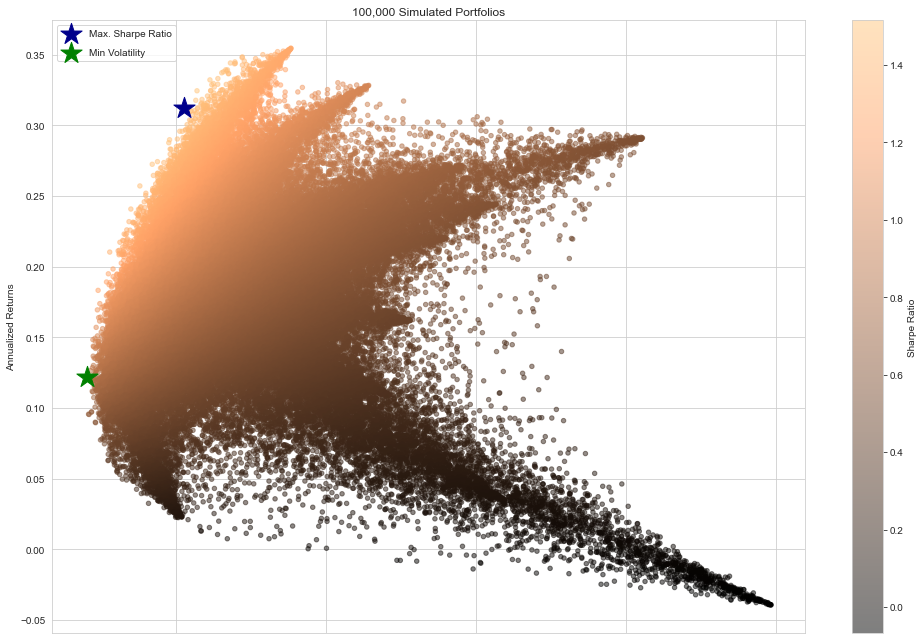

In [163]:
# Plot 100,000 simulated PFs
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='copper', alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
print(f'Min Volatility : {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

In [165]:
# Annualized PF standard deviation
def portfolio_std(wt, rt=None, cov=None):
    return np.sqrt(wt @ cov @ wt * periods_per_year)

# Annualized PF returns
def portfolio_returns(wt, rt=None, cov=None):
    return (wt @ rt + 1) ** periods_per_year - 1

# Annualized PF returns & standard deviation
def portfolio_performance(wt, rt, cov):
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

# negative Sharp Ratio for scipy's minimize function for optimization
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x))-1}

def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio, # object function(UDF)
                    x0=x0, # initial value
                    args=(mean_ret, cov), # parameters for object function except for initial value
                    method='SLSQP', # optimal solution method
                    bounds=((-1 if short else 0, 1),) * n_assets, # threshold
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

In [119]:
# Compute efficient frontier
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq', 'fun': lambda x: ret_(x) - target}, weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

# min volatility PF
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

In [120]:
# get random PF
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)
simul_perf.describe()

,Annualized Standard Deviation,Annualized Returns,Sharpe Ratio
count,100000.000000,100000.000000,100000.000000
mean,0.276964,0.193159,0.721600
std,0.075078,0.061665,0.231681
min,0.149670,0.008699,0.021407
25%,0.226374,0.153546,0.564563
50%,0.258736,0.182955,0.709305
75%,0.309772,0.223075,0.849426
max,0.724380,0.450271,1.585761


In [173]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.205672
Annualized Returns               0.312057
Sharpe Ratio                     1.514829
Name: 17583, dtype: float64

In [175]:
# Get Max Sharpe PF
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.307927
sd     0.196022
sr     1.568333
dtype: float64

In [176]:
# Get Min Volatility PF
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)
min_vol_perf

(0.12264810828023953, 0.13370992950516153)

In [178]:
# Get Efficient PFs
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))
eff_pf.tail()

0.206494    0.322477
0.213506    0.330516
0.223738    0.338555
0.238088    0.346595
0.274148    0.354634
dtype: float64

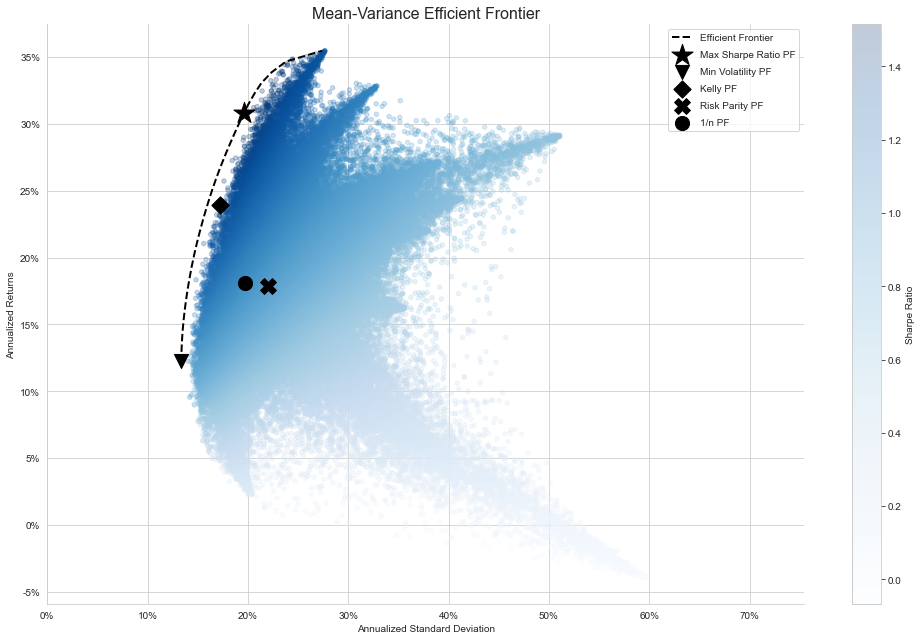

In [179]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25,
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k', label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')

ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();